In [ ]:
from python.analysis.Utils import init_notebook
%init_notebook

import os

from dataclasses import dataclass

import awkward as ak
import numpy as np
import pandas as pd

from scipy.interpolate import interp1d

from python.analysis import cross_section, Plots
from apps import cex_toy_generator, cex_analyse

cross_section.PlotStyler.SetPlotStyle(dpi = 100, extend_colors = True)

from pyunfold.callbacks import setup_callbacks_regularizer, Logger
from pyunfold.mix import Mixer
from pyunfold.teststat import get_ts
from pyunfold.priors import setup_prior
from pyunfold.utils import cast_to_array

def CreateConfig(PDSP : int = 1, p_init : float = 1000, events : int = 50805, seed : int = None, verbose : bool = False, modified_PDFs : dict[np.array] = None, scale_factors : dict[float] = None, step : float = 2, smearing : str = "double_crystal_ball", beam_profile : str = "gaussian"):
    return {
    "events" : events,
    "step" : step,
    "p_init" : p_init,
    "beam_profile" : beam_profile,
    "beam_width" : 60,


    "smearing_params" : {
        "KE_init" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_init/{smearing}.json",
        "KE_int" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_int/{smearing}.json",
        "z_int" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/z_int/{smearing}.json"
    },
    # "smearing_params" : {
    #     "KE_init" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_ff_resolution.json",
    #     "KE_int" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_int_resolution.json",
    #     "z_int" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/track_length_resolution.json"
    # },
    "reco_region_fractions" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/reco_regions/reco_region_fractions.hdf5",
    "beam_selection_efficiencies" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/pi_beam_efficiency/beam_selection_efficiencies_true.hdf5",
    "mean_track_score_kde" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/meanTrackScoreKDE/kdes.dill",
    "pdf_scale_factors" : scale_factors,
    "verbose" : verbose,
    "seed" : seed,
    "modified_PDFs" : modified_PDFs
    }

def iterative_unfold(data=None, data_err=None, response=None,
                     response_err=None, efficiencies=None,
                     efficiencies_err=None, prior=None, ts='ks',
                     ts_stopping=0.01, max_iter=100, cov_type='multinomial',
                     return_iterations=False, callbacks=None):
    """Performs iterative unfolding. Custom method which returns the covariance matrix.

    Parameters
    ----------
    data : array_like
        Input observed data distribution.
    data_err : array_like
        Uncertainties of the input observed data distribution. Must be the
        same shape as ``data``.
    response : array_like
        Response matrix.
    response_err : array_like
        Uncertainties of response matrix. Must be the same shape as
        ``response``.
    efficiencies : array_like
        Detection efficiencies for the cause distribution.
    efficiencies_err : array_like
        Uncertainties of detection efficiencies. Must be the same shape as
        ``efficiencies``.
    prior : array_like, optional
        Prior distribution to use in unfolding. If None, then a uniform
        (or flat) prior will be used. If array_like, then must have the same
        shape as ``efficiencies`` (default is None).
    ts : {'ks', 'chi2', 'bf', 'rmd'}
        Test statistic to use for stopping condition (default is 'ks').
        For more information about the available test statistics, see the
        `Test Statistics API documentation <api.rst#test-statistics>`__.
    ts_stopping : float, optional
        Test statistic stopping condition. At each unfolding iteration, the
        test statistic is computed between the current and previous iteration.
        Once the test statistic drops below ts_stopping, the unfolding
        procedure is stopped (default is 0.01).
    max_iter : int, optional
        Maximum number of iterations to allow (default is 100).
    cov_type : {'multinomial', 'poisson'}
        Whether to use the Multinomial or Poisson form for the covariance
        matrix (default is 'multinomial').
    return_iterations : bool, optional
        Whether to return unfolded distributions for each iteration
        (default is False).
    callbacks : list, optional
        List of ``pyunfold.callbacks.Callback`` instances to be applied during
        unfolding (default is None, which means no Callbacks are applied).

    Returns
    -------
    unfolded_result : dict
        Returned if ``return_iterations`` is False (default). Dictionary
        containing the final unfolded distribution, associated uncertainties,
        and test statistic information.

        The returned ``dict`` has the following keys:

            unfolded
                Final unfolded cause distribution
            stat_err
                Statistical uncertainties on the unfolded cause distribution
            sys_err
                Systematic uncertainties on the unfolded cause distribution
                associated with limited statistics in the response matrix
            ts_iter
                Final test statistic value
            ts_stopping
                Test statistic stopping criterion
            num_iterations
                Number of unfolding iterations
            unfolding_matrix
                Unfolding matrix

    unfolding_iters : pandas.DataFrame
        Returned if ``return_iterations`` is True. DataFrame containing the
        unfolded distribution, associated uncertainties, test statistic
        information, etc. at each iteration.
    """
    # Validate user input
    inputs = {'data': data,
              'data_err': data_err,
              'response': response,
              'response_err': response_err,
              'efficiencies': efficiencies,
              'efficiencies_err': efficiencies_err
              }
    for name in inputs:
        if inputs[name] is None:
            raise ValueError('The input for {} must not be None.'.format(name))
        elif np.amin(inputs[name]) < 0:
            raise ValueError('The items in {} must be non-negative.'.format(name))

    data, data_err = cast_to_array(data, data_err)
    response, response_err = cast_to_array(response, response_err)
    efficiencies, efficiencies_err = cast_to_array(efficiencies,
                                                   efficiencies_err)

    num_causes = len(efficiencies)

    # Setup prior
    prior = setup_prior(prior=prior, num_causes=num_causes)

    # Define first prior counts distribution
    n_c = np.sum(data) * prior

    # Setup Mixer
    mixer = Mixer(data=data,
                  data_err=data_err,
                  efficiencies=efficiencies,
                  efficiencies_err=efficiencies_err,
                  response=response,
                  response_err=response_err,
                  cov_type=cov_type)

    # Setup test statistic
    ts_obj = get_ts(ts)
    ts_func = ts_obj(tol=ts_stopping,
                     num_causes=num_causes,
                     TestRange=[0, 1e2],
                     verbose=False)

    unfolding_iters = _unfold_custom(prior=n_c,
                                     mixer=mixer,
                                     ts_func=ts_func,
                                     max_iter=max_iter,
                                     callbacks=callbacks)

    if return_iterations:
        return unfolding_iters
    else:
        unfolded_result = dict(unfolding_iters.iloc[-1])
        return unfolded_result


def _unfold_custom(prior=None, mixer=None, ts_func=None, max_iter=100,
            callbacks=None):
    """Perform iterative unfolding. Custom version of the method which just returns the covariance method in addition to the regular output

    Parameters
    ----------
    prior : array_like
        Initial cause distribution.
    mixer : pyunfold.Mix.Mixer
        Mixer to perform the unfolding.
    ts_func : pyunfold.Utils.TestStat
        Test statistic object.
    max_iter : int, optional
        Maximum allowed number of iterations to perform.
    callbacks : list, optional
        List of ``pyunfold.callbacks.Callback`` instances to be applied during
        unfolding (default is None, which means no Callbacks are applied).

    Returns
    -------
    unfolding_iters : pandas.DataFrame
        DataFrame containing the unfolded result for each iteration.
        Each row in unfolding_result corresponds to an iteration.
    """
    # Set up callbacks, regularizer Callbacks are treated separately
    callbacks, regularizer = setup_callbacks_regularizer(callbacks)
    callbacks.on_unfolding_begin()

    current_n_c = prior.copy()
    iteration = 0
    unfolding_iters = []
    while not ts_func.pass_tol() and iteration < max_iter:
        callbacks.on_iteration_begin(iteration=iteration)

        # Perform unfolding for this iteration
        unfolded_n_c = mixer.smear(current_n_c)
        iteration += 1
        status = {'unfolded': unfolded_n_c,
                  'stat_err': mixer.get_stat_err(),
                  'sys_err': mixer.get_MC_err(),
                  'num_iterations': iteration,
                  'unfolding_matrix': mixer.Mij,
                  'covariance_matrix': mixer.get_cov()}

        if regularizer:
            # Will want the nonregularized distribution for the final iteration
            unfolded_nonregularized = status['unfolded'].copy()
            regularizer.on_iteration_end(iteration=iteration, status=status)

        ts_iter = ts_func.calc(status['unfolded'], current_n_c)
        status['ts_iter'] = ts_iter
        status['ts_stopping'] = ts_func.tol

        callbacks.on_iteration_end(iteration=iteration, status=status)
        unfolding_iters.append(status)

        # Updated current distribution for next iteration of unfolding
        current_n_c = status['unfolded'].copy()

    # Convert unfolding_iters list of dictionaries to a pandas DataFrame
    unfolding_iters = pd.DataFrame.from_records(unfolding_iters)

    # Replace final folded iteration with un-regularized distribution
    if regularizer:
        last_iteration_index = unfolding_iters.index[-1]
        unfolding_iters.at[last_iteration_index, 'unfolded'] = unfolded_nonregularized

    callbacks.on_unfolding_end(status=status)

    return unfolding_iters


def UnfoldXS(max_iter : int, observed : dict, observed_err : dict, response_matrices : dict, energy_slices : cross_section.Slices):
    r = cross_section.Unfold.Unfold(observed, observed_err, response_matrices, max_iter = max_iter, ts_stop = 1E-8)

    n_incident_unfolded = cross_section.EnergySlice.NIncident(r["init"]["unfolded"], r["int"]["unfolded"])

    n_incident_unfolded_err = np.sqrt(r["int"]["stat_err"]**2 + np.cumsum(r["init"]["stat_err"]**2 + r["int"]["stat_err"]**2))

    slice_dEdX = cross_section.EnergySlice.Slice_dEdX(energy_slices, cross_section.Particle.from_pdgid(211))

    xs_unfolded = cross_section.EnergySlice.CrossSection(r["int_ex"]["unfolded"][1:], r["int"]["unfolded"][1:], n_incident_unfolded[1:], slice_dEdX, energy_slices.width, r["int_ex"]["stat_err"][1:], r["int"]["stat_err"][1:], n_incident_unfolded_err[1:])
    return xs_unfolded

env: PYTHONPATH=/home/sb16165/Documents/pi0-analysis/analysis


In [4]:
args = cross_section.ApplicationArguments.ResolveConfig(cross_section.LoadConfiguration("work/2023/beam_selections/new_selection_true/analysis_config.json"))
toy_template = cross_section.Toy(file = "work/2023/beam_selections/new_selection_true/xs_toy_cb_2cm_template.hdf5")
template_input = cross_section.AnalysisInput.CreateAnalysisInputToy(toy_template)

In [68]:
config = cross_section.LoadConfiguration("work/2023/beam_selections/new_selection_true/toy_data_config.json")
config["events"] = 1E5
toy_obs = cross_section.Toy(df = cex_toy_generator.run(config))

data_obs = cross_section.AnalysisInput.CreateAnalysisInputToy(toy_obs)

mean_track_score_bins = np.linspace(0, 1, 21, True)
fit_results = cex_analyse.RegionFit(data_obs, args.energy_slices, mean_track_score_bins, cross_section.AnalysisInput.CreateAnalysisInputToy(toy_template), single_bin = True)

starting batch : 0, cpus : 10

Simulating |████████████████████████████████████████| 1/1 [100%] in 4.8s (0.21/s) 


Done! Creating dataframe...

total_inelastic 99999

decay 1

double_charge_exchange 5233

pion_production 46989

absorption 6990

quasielastic 31431

charge_exchange 9356

1

'BeamSelectionEfficiency' executed in 0.0078s

'GenerateRecoRegions' executed in 0.1276s

'MeanTrackScore' executed in 0.4563s

'main' executed in 5.7681s

  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3', 'mean_track_score']
     nbins: {'channel_0': 1, 'channel_1': 1, 'channel_2': 1, 'channel_3': 1, 'mean_track_score': 20}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfactor'), ('mu_3', 'normfactor')]
parameters: ['mu_0', 'mu_1', 'mu_2', 'mu_3']
  nauxdata: 0
   auxdata: []
model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-18878321.83569074])


In [69]:
process = "charge_exchange"

# Correlation matrices
need to make correlation matrix for:
 - n_initial
 - n_end
 - n_interact

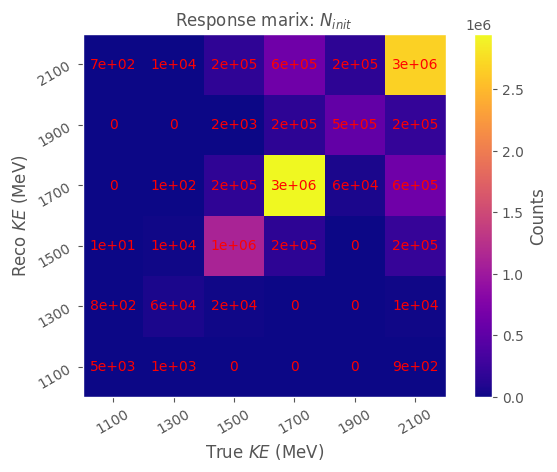

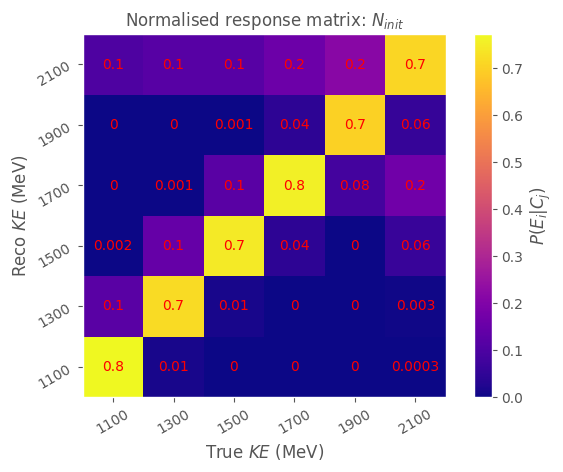

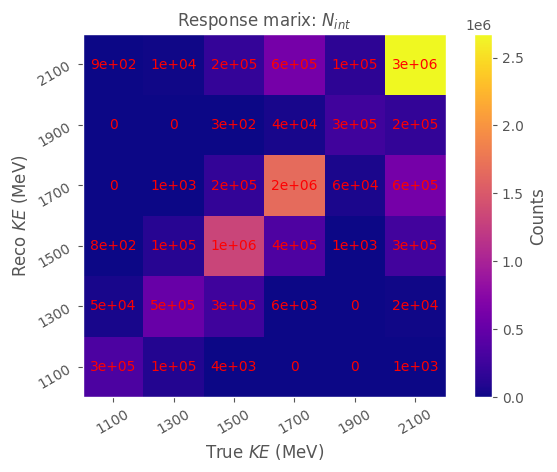

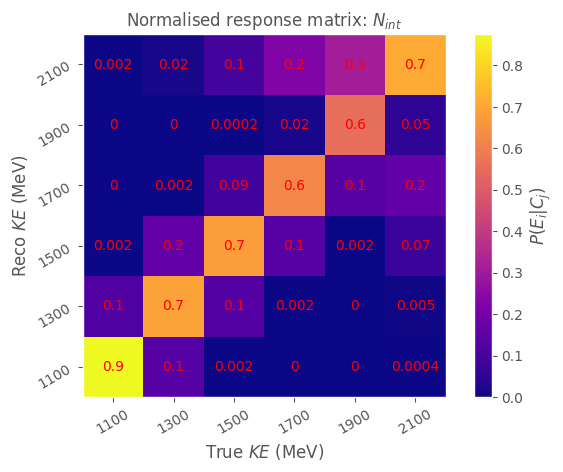

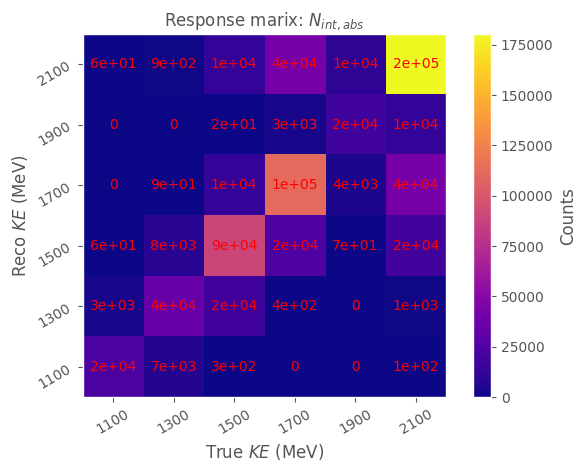

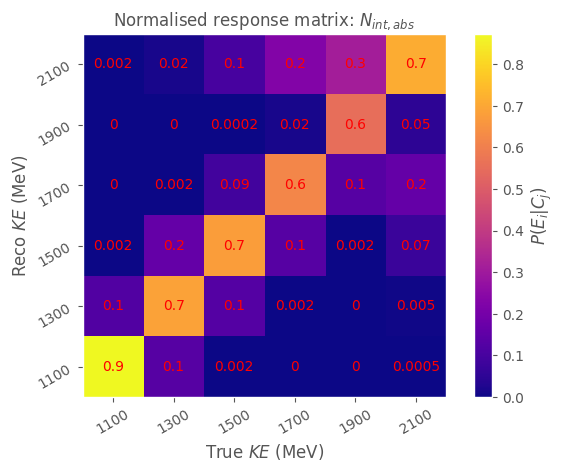

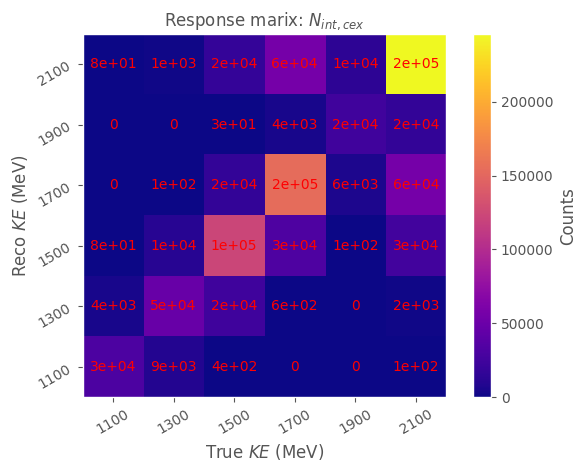

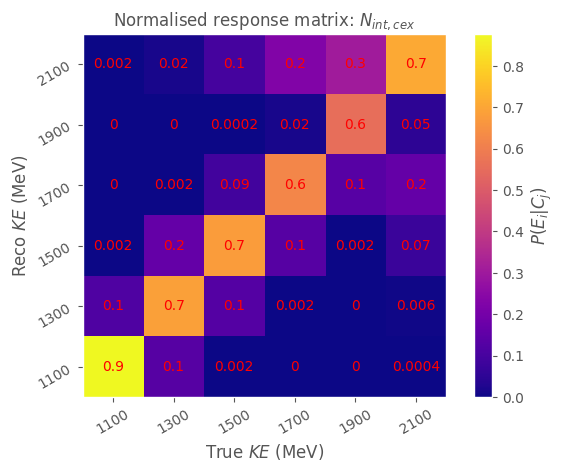

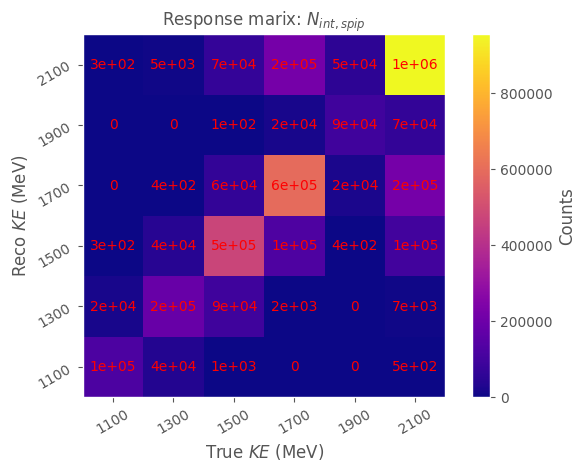

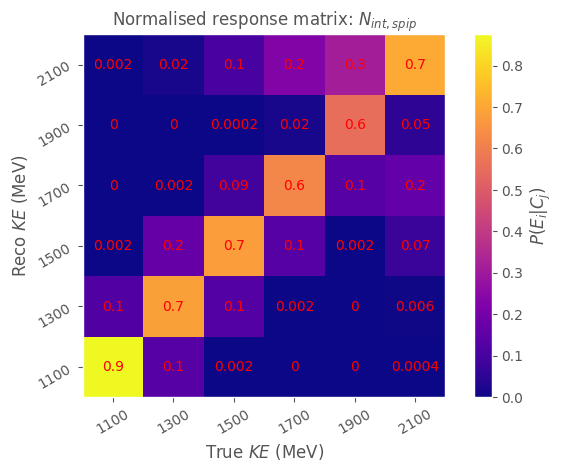

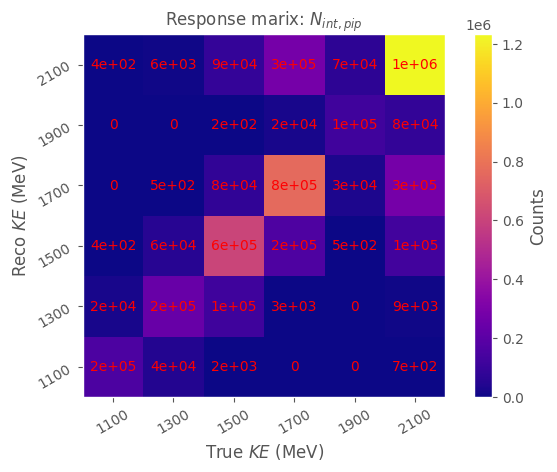

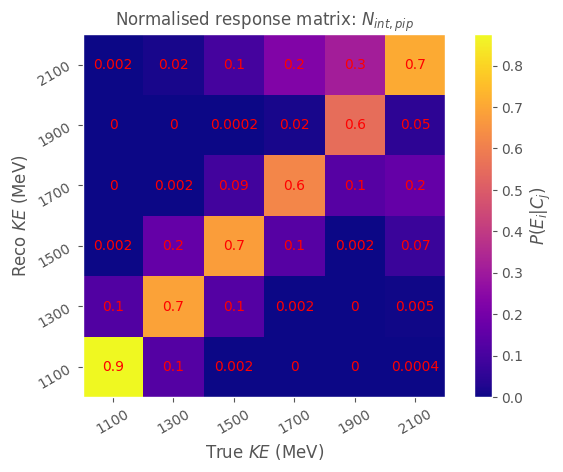

In [308]:
resp = cross_section.Unfold.CalculateResponseMatrices(template_input, None, args.energy_slices, True, Plots.PlotBook.null, None)

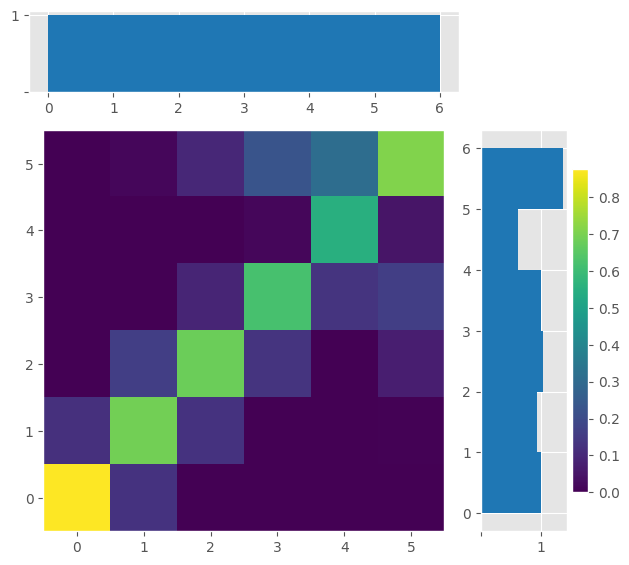

In [209]:
Plot(np.flip(resp["pion_production"][0]))

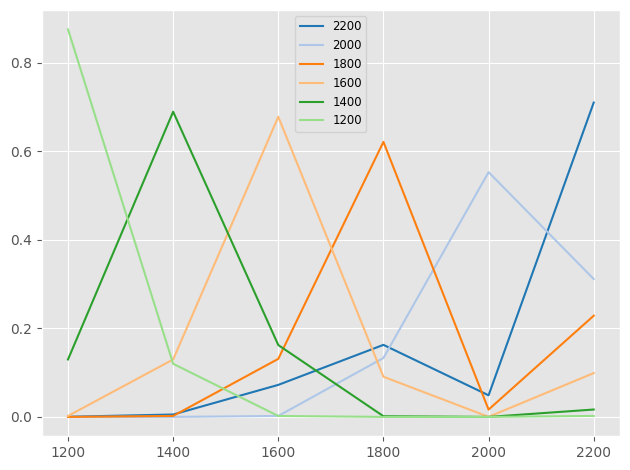

In [61]:
for i in range(resp["pion_production"][0].shape[0]):
    Plots.Plot(args.energy_slices.pos_overflow, resp["pion_production"][0][:, i], newFigure = False, label = args.energy_slices.pos_overflow[i])

# Generate observations

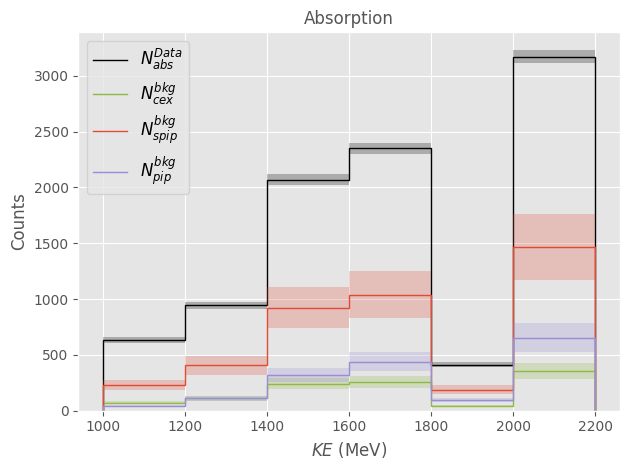

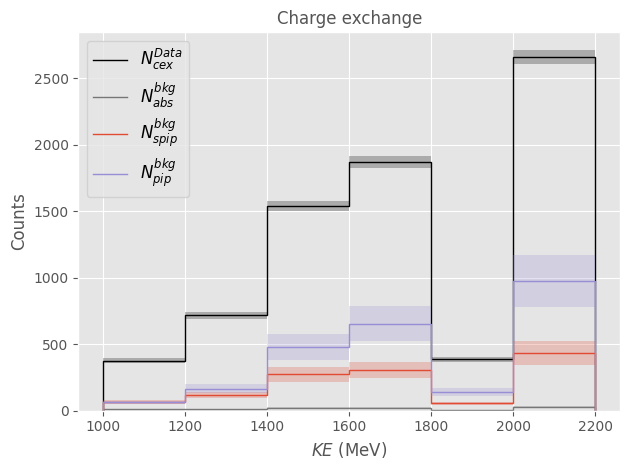

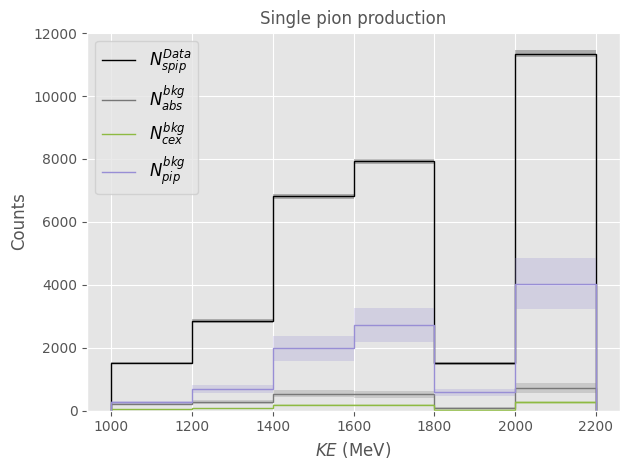

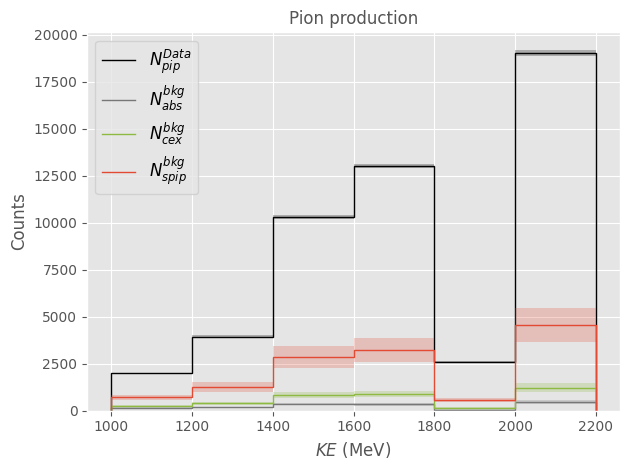

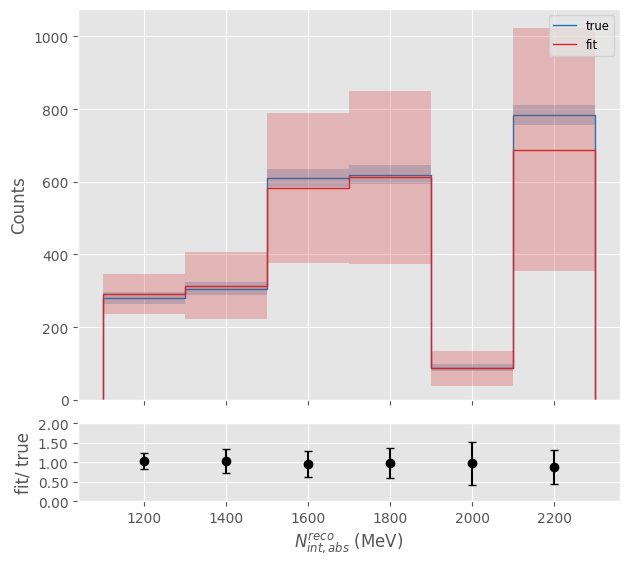

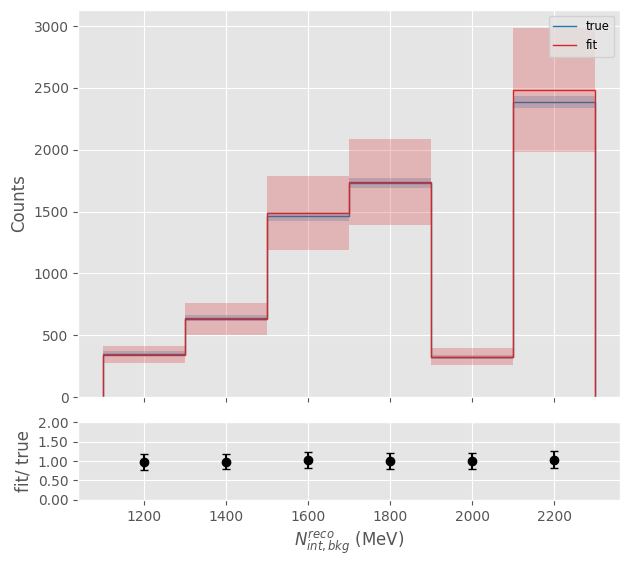

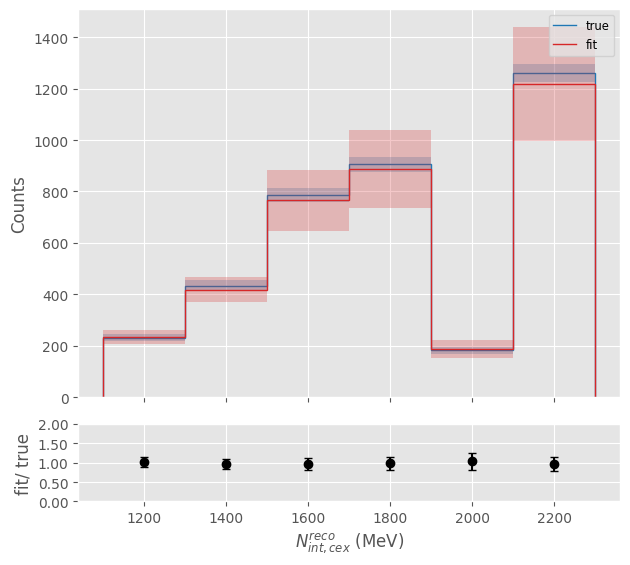

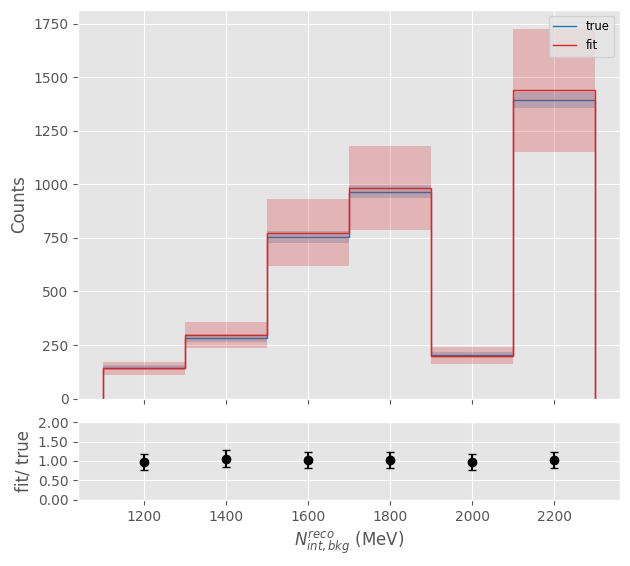

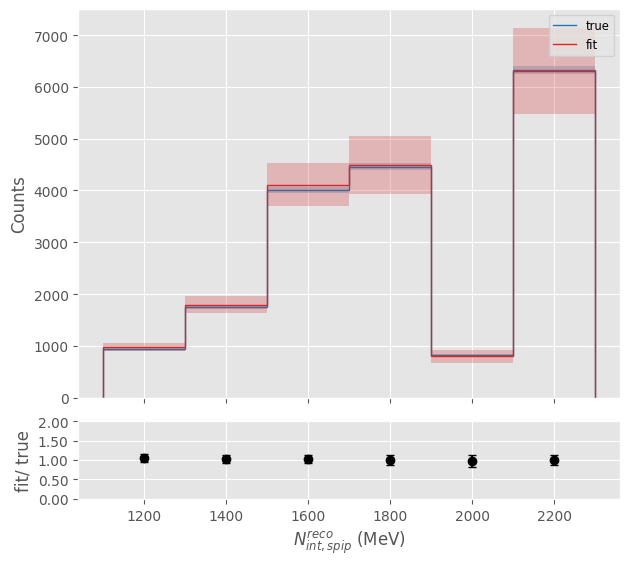

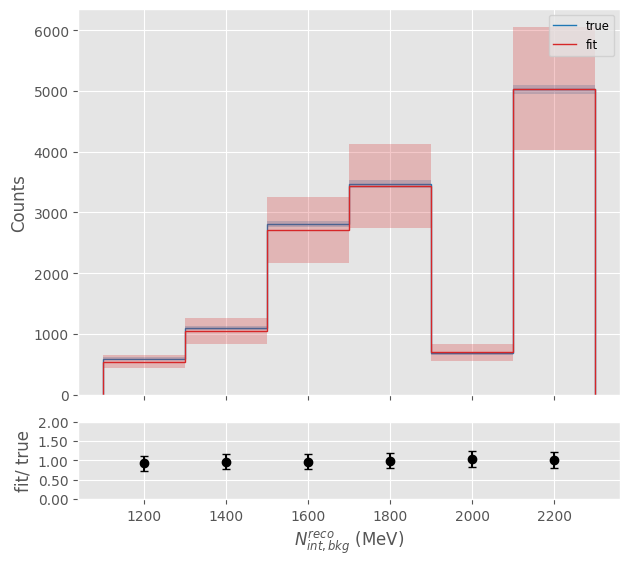

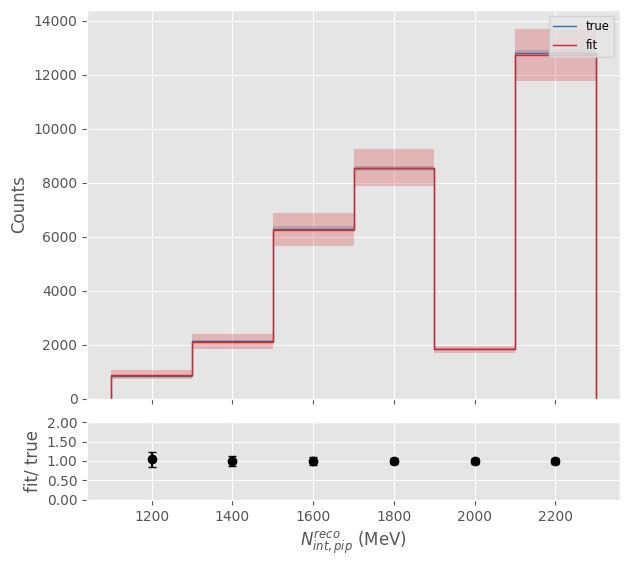

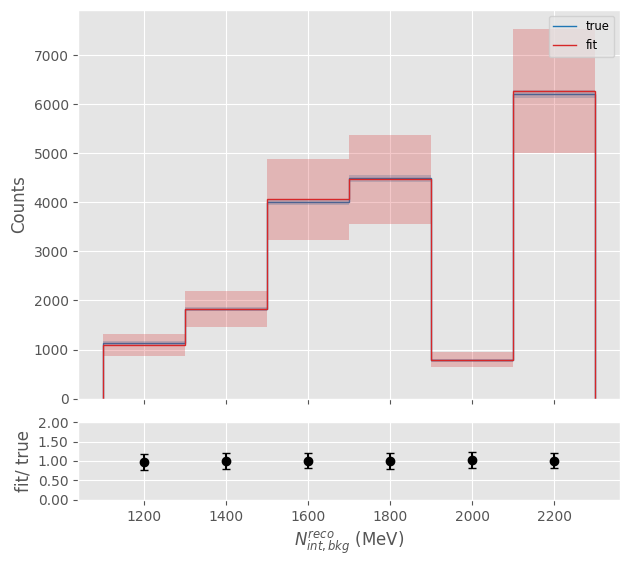

In [71]:
histograms_true_obs, histograms_reco_obs, histograms_reco_obs_err = cex_analyse.BackgroundSubtraction(data_obs, "charge_exchange", args.energy_slices, fit_results, True, True, template_input, True)

# Unfolding

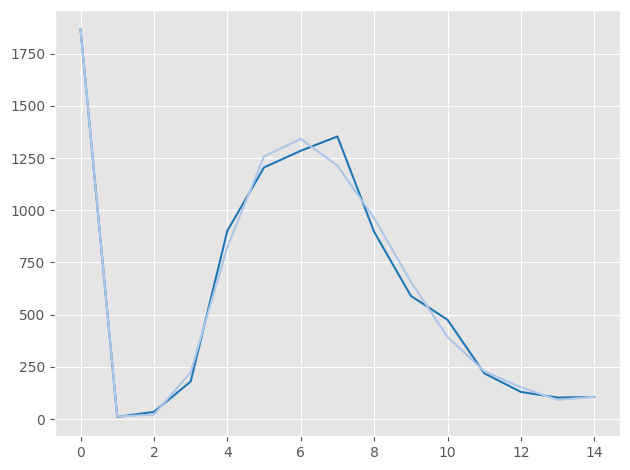

In [183]:
from pyunfold.callbacks import SplineRegularizer
from scipy.interpolate import UnivariateSpline
from scipy.stats import gaussian_kde

y = histograms_reco_obs["int_ex"]
x = np.arange(len(y), dtype = float)

uvs = UnivariateSpline(x, y, k = 5, s = 5E4)
# kde = gaussian_kde(y)

# cdf = np.cumsum(y)
# cdf = cdf / cdf [-1]

Plots.Plot(x, y)
Plots.Plot(x, uvs(x), newFigure = False)
# Plots.Plot(x, kde(y), newFigure = False)

reg = {k : SplineRegularizer(degree = 5, smooth = 1E4) for k in histograms_reco_obs}


In [184]:
true_hists = template_input.CreateHistograms(args.energy_slices, process, False, None)
results = cross_section.Unfold.Unfold(histograms_reco_obs, histograms_reco_obs_err, resp, priors = true_hists, ts_stop = 1E-5, ts = "ks", max_iter = 5, verbose = True)
results_reg = cross_section.Unfold.Unfold(histograms_reco_obs, histograms_reco_obs_err, resp, priors = true_hists, regularizers = reg, ts_stop = 1E-5, ts = "ks", max_iter = 5, verbose = True)


Iteration 1: ts = 0.0017, ts_stopping = 1e-05
Iteration 2: ts = 0.0006, ts_stopping = 1e-05
Iteration 3: ts = 0.0005, ts_stopping = 1e-05
Iteration 4: ts = 0.0004, ts_stopping = 1e-05
Iteration 5: ts = 0.0003, ts_stopping = 1e-05
Iteration 1: ts = 0.0006, ts_stopping = 1e-05
Iteration 2: ts = 0.0005, ts_stopping = 1e-05
Iteration 3: ts = 0.0005, ts_stopping = 1e-05
Iteration 4: ts = 0.0004, ts_stopping = 1e-05
Iteration 5: ts = 0.0004, ts_stopping = 1e-05
Iteration 1: ts = 0.0113, ts_stopping = 1e-05
Iteration 2: ts = 0.0064, ts_stopping = 1e-05
Iteration 3: ts = 0.0057, ts_stopping = 1e-05
Iteration 4: ts = 0.0052, ts_stopping = 1e-05
Iteration 5: ts = 0.0047, ts_stopping = 1e-05
Iteration 1: ts = 0.0017, ts_stopping = 1e-05
Iteration 2: ts = 0.0008, ts_stopping = 1e-05
Iteration 3: ts = 0.0007, ts_stopping = 1e-05
Iteration 4: ts = 0.0006, ts_stopping = 1e-05
Iteration 5: ts = 0.0005, ts_stopping = 1e-05
Iteration 1: ts = 0.0008, ts_stopping = 1e-05
Iteration 2: ts = 0.0008, ts_stopp

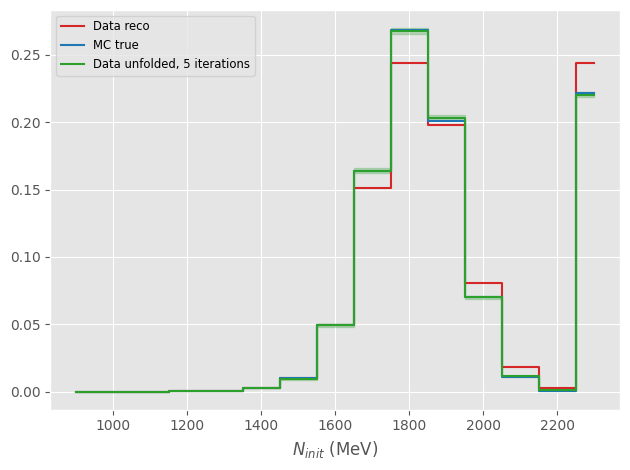

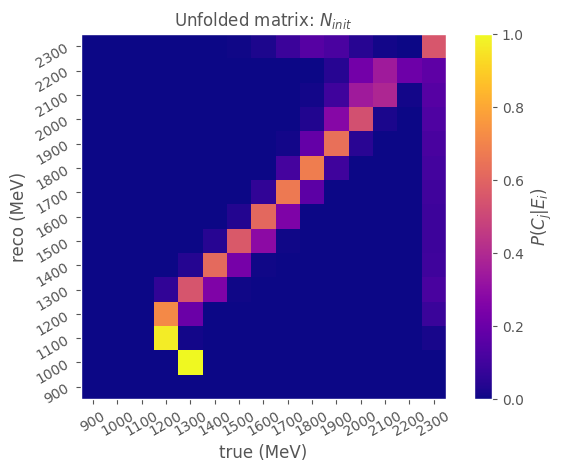

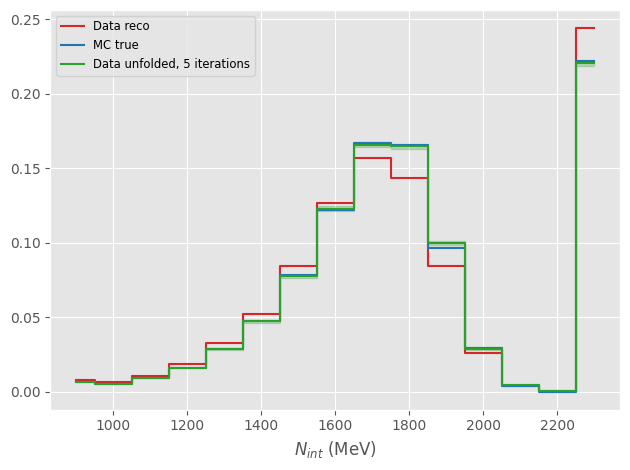

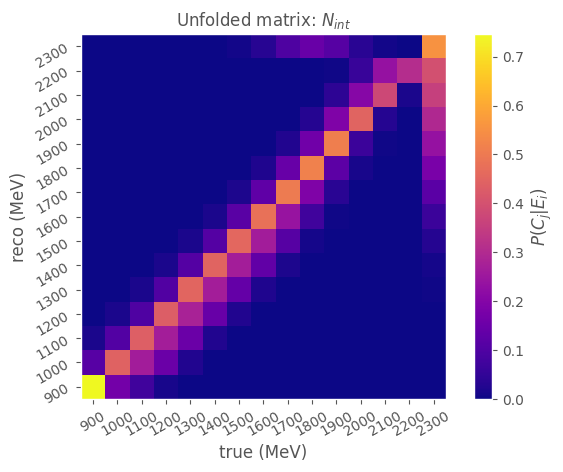

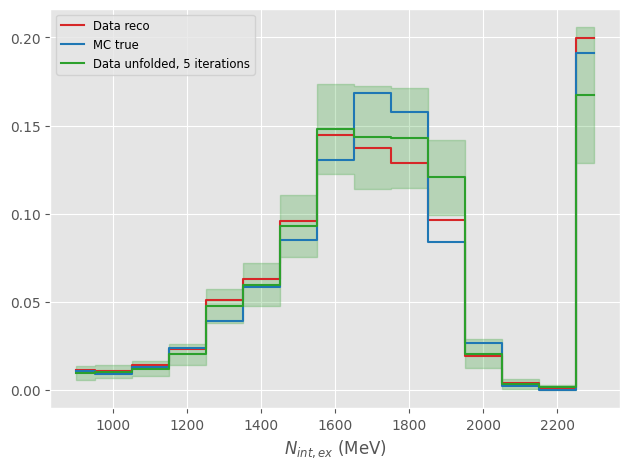

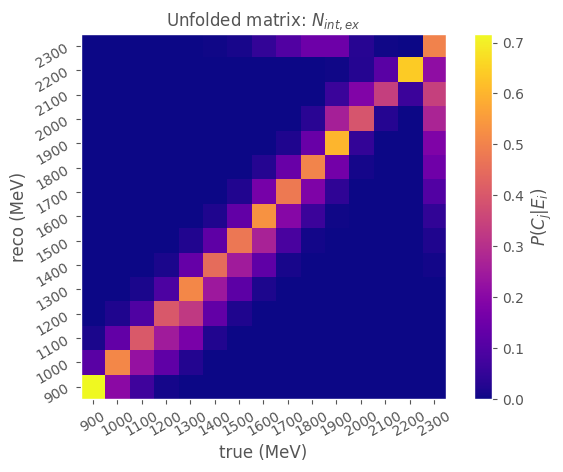

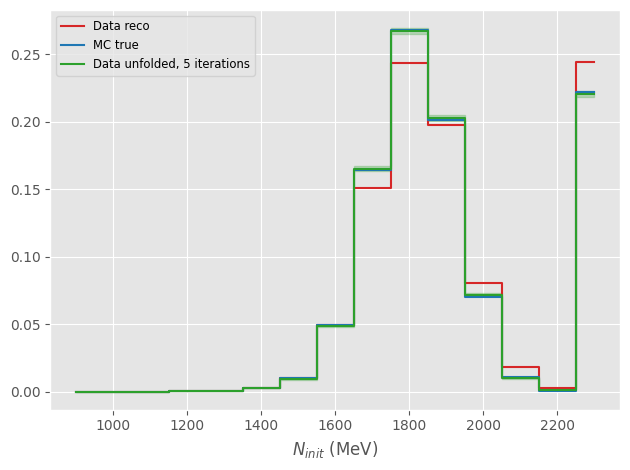

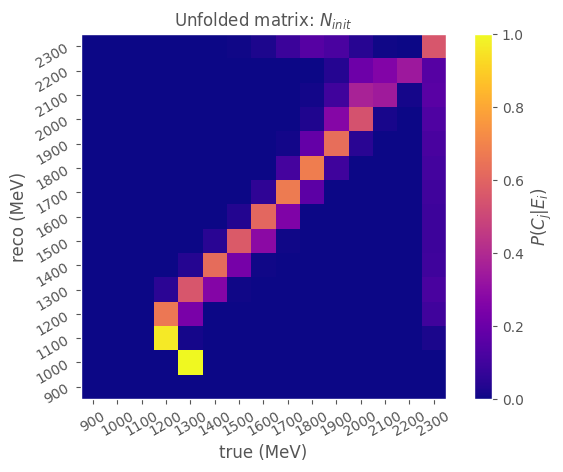

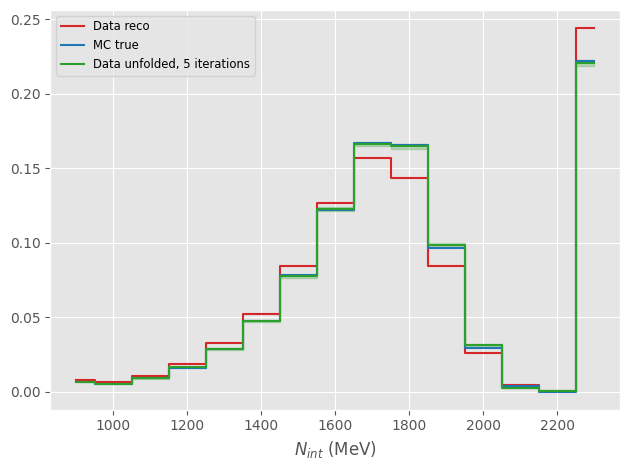

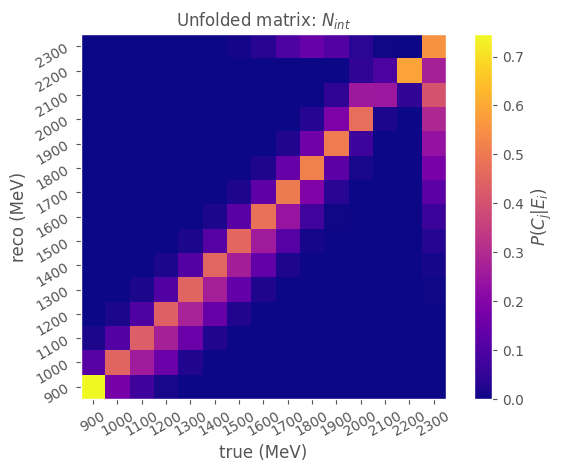

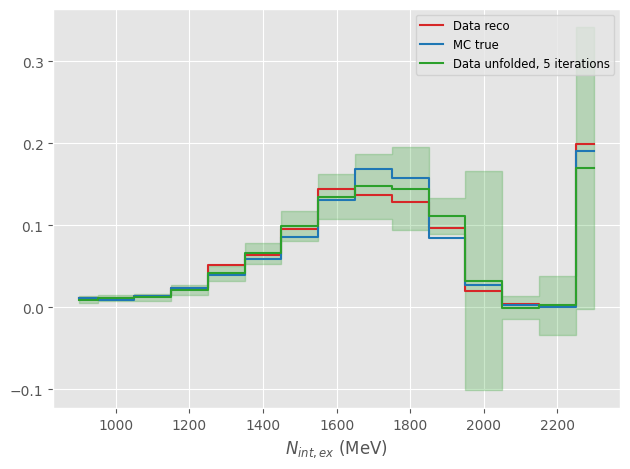

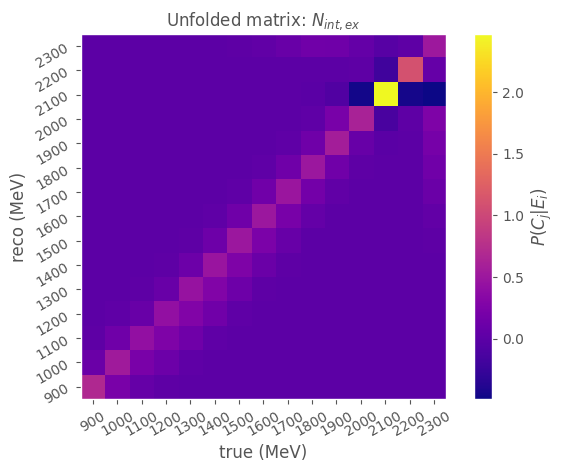

In [185]:
labels = {"init" : "$N_{init}$", "int" : "$N_{int}$", "int_ex" : "$N_{int, ex}$"}

for k in results:
    cross_section.Unfold.PlotUnfoldingResults(histograms_reco_obs[k], histograms_true_obs[k], results[k], args.energy_slices, labels[k])
for k in results:
    cross_section.Unfold.PlotUnfoldingResults(histograms_reco_obs[k], histograms_true_obs[k], results_reg[k], args.energy_slices, labels[k])


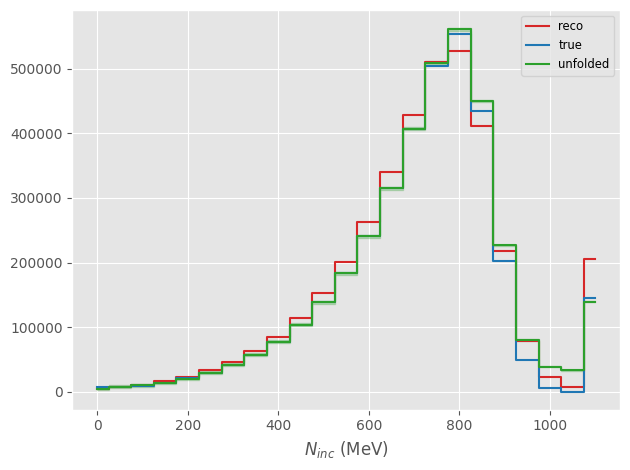

In [14]:
n_incident_unfolded = cross_section.EnergySlice.NIncident(results["init"]["unfolded"], results["int"]["unfolded"])
n_incident_unfolded_err = np.sqrt(results["int"]["stat_err"]**2 + np.cumsum(results["init"]["stat_err"]**2 + results["int"]["stat_err"]**2))

Plots.Plot(energy_bins[::-1], histograms_reco_obs["inc"], style = "step", label = "reco", color = "C6")
Plots.Plot(energy_bins[::-1], histograms_true_obs["inc"], style = "step", label = "true", color = "C0", newFigure = False)
Plots.Plot(energy_bins[::-1], n_incident_unfolded, yerr = n_incident_unfolded_err, style = "step", label = "unfolded", xlabel = "$N_{inc}$ (MeV)", color = "C4", newFigure = False)

# Cross section

{'true': 1.6578703132276944,
 'reco': 498.35512171910864,
 'unfolded': 8.544778916074828}

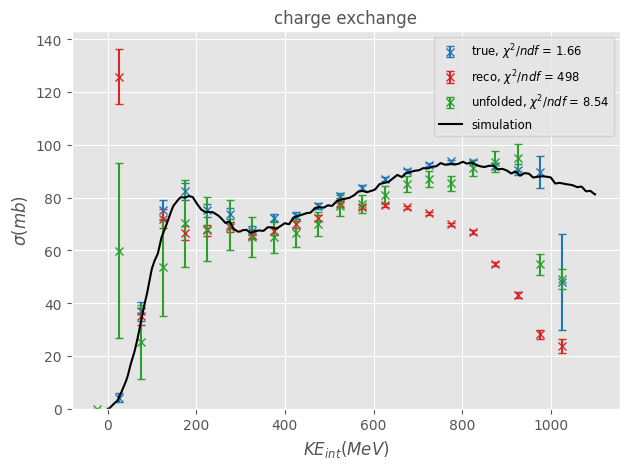

In [15]:
xs_sim = cross_section.GeantCrossSections(energy_range = [0, 1050])
slice_dEdX = cross_section.EnergySlice.Slice_dEdX(energy_slice, cross_section.Particle.from_pdgid(211))

xs_true = cross_section.EnergySlice.CrossSection(histograms_true_obs["int_ex"][1:], histograms_true_obs["int"][1:], histograms_true_obs["inc"][1:], slice_dEdX, energy_slice.width)

xs_reco = cross_section.EnergySlice.CrossSection(histograms_reco_obs["int_ex"][1:], histograms_reco_obs["int"][1:], histograms_reco_obs["inc"][1:], slice_dEdX, energy_slice.width)

xs_unfolded = cross_section.EnergySlice.CrossSection(results["int_ex"]["unfolded"][1:], results["int"]["unfolded"][1:], n_incident_unfolded[1:], slice_dEdX, energy_slice.width, results["int_ex"]["stat_err"][1:], results["int"]["stat_err"][1:], n_incident_unfolded_err[1:])

xs = {
    "true" : xs_true,
    "reco" : xs_reco,
    f"unfolded" : xs_unfolded
}

colors = ["C0", "C6", "C4"]
colors = {k : colors[i] for i, k in enumerate(xs)}

cross_section.PlotXSComparison(xs, energy_slice, process, colors = colors)

# unfolding iterations

In [76]:
output = []
iters = [1, 2, 3, 4, 6, 10, 16, 100]
for i in iters:
    output.append(UnfoldXS(i, histograms_reco_obs, histograms_reco_obs_err, resp, energy_slice))
output = np.array(output)

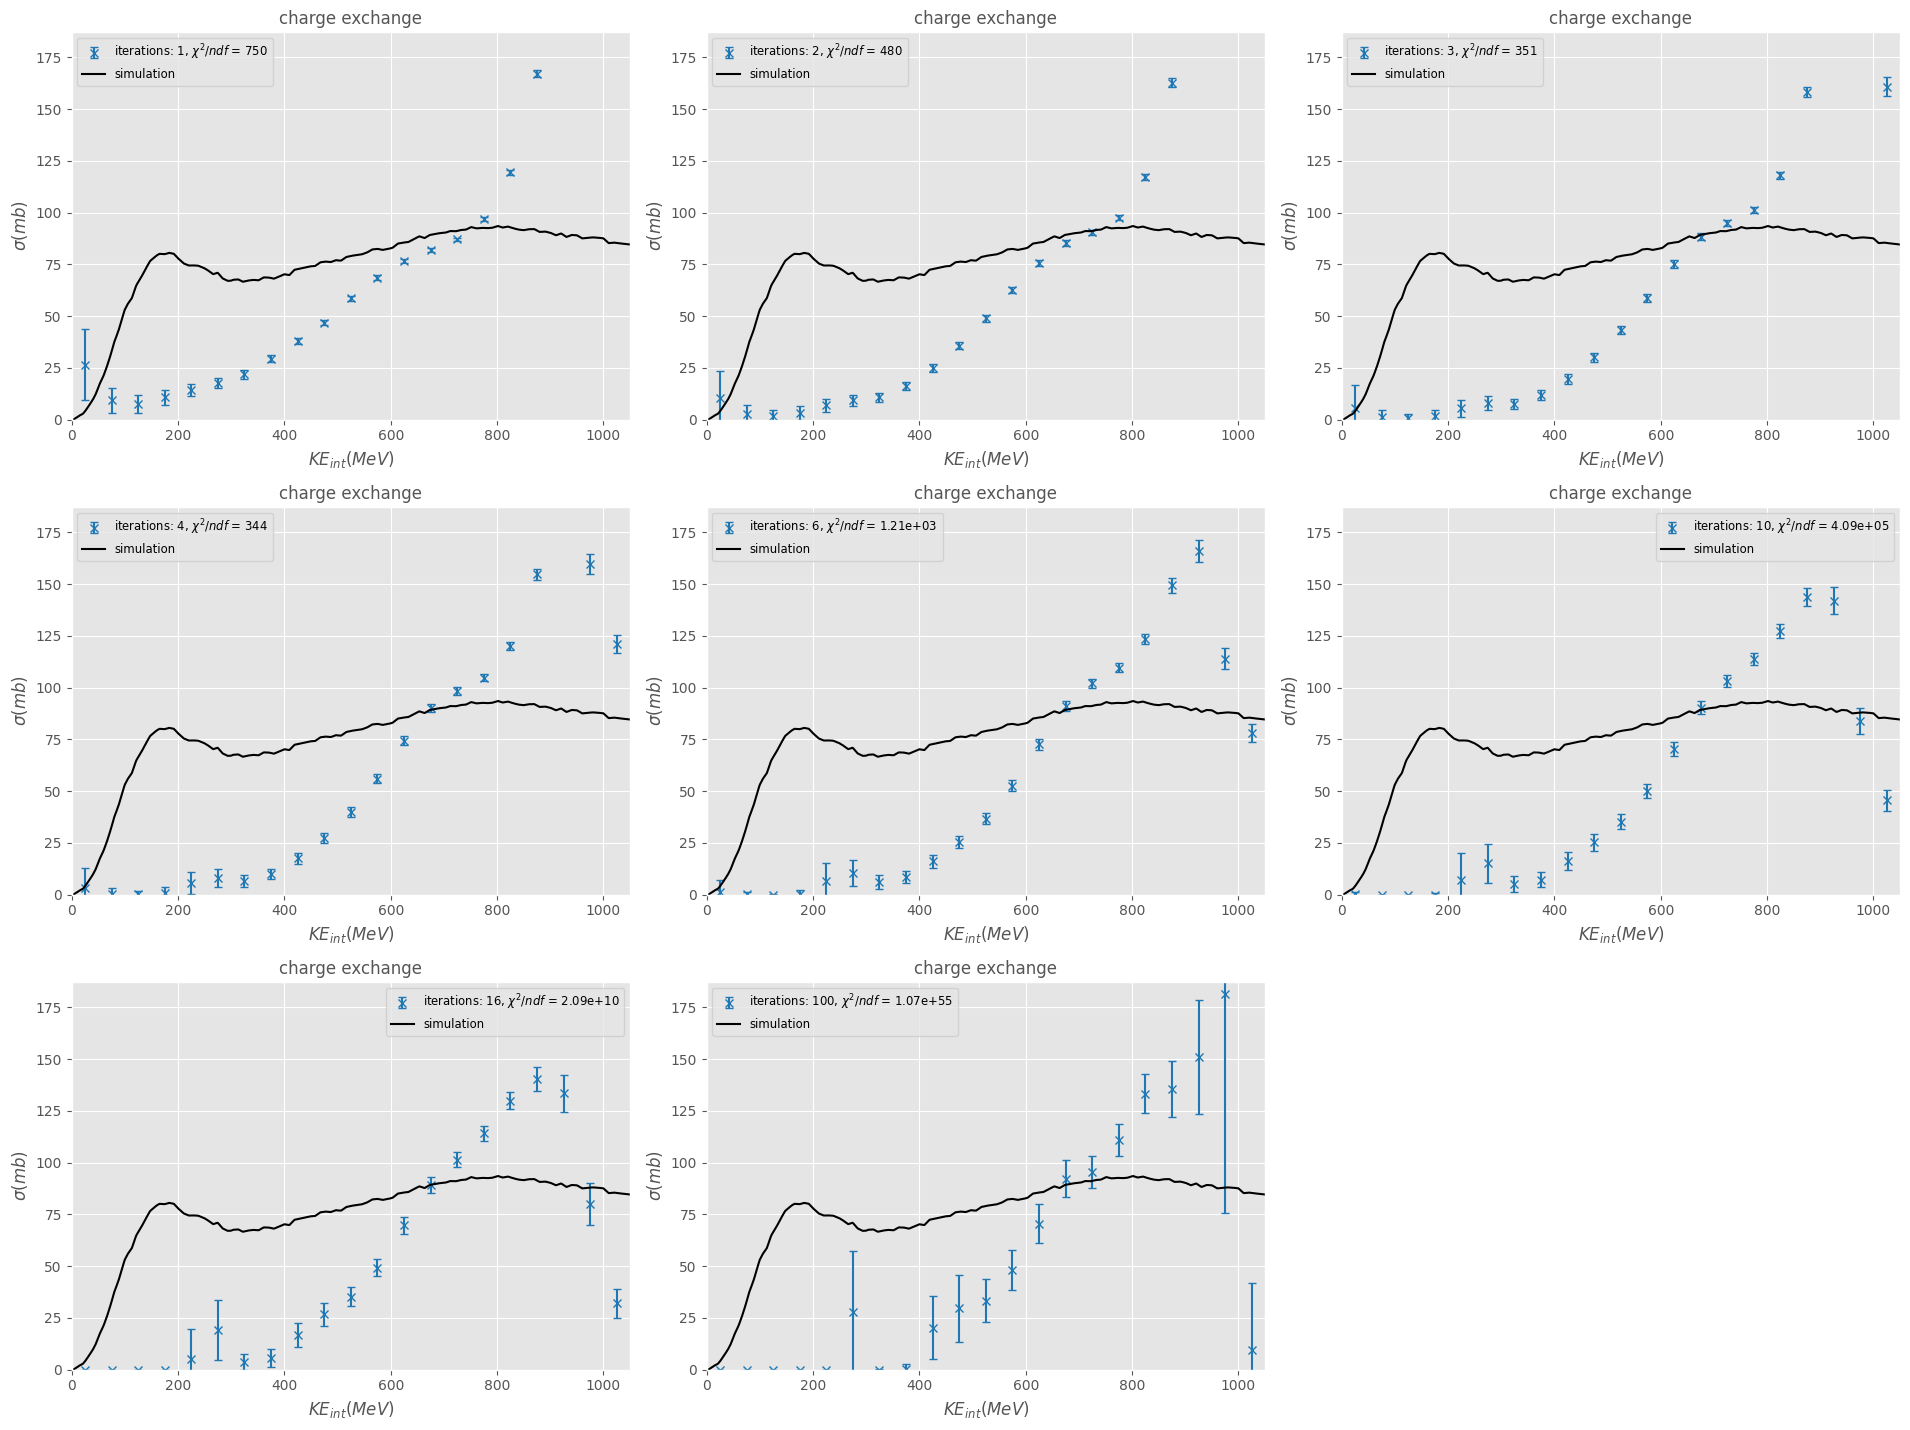

In [77]:
chi_sqrs = []
for n, i in Plots.IterMultiPlot(iters, xlim=(energy_slice.min_pos, energy_slice.max_pos), ylim = (0, np.nanmax(output))):
    chi_sqrs.append(cross_section.PlotXSComparison({f"iterations: {i}" : output[n]}, energy_slice, process, {f"iterations: {i}" : "C0"}, newFigure = False))
    Plots.plt.ylim(0)
# book.Save()

In [14]:
table = pd.DataFrame({list(i.keys())[0]: [list(i.values())[0]] for i in chi_sqrs}, index = ["$\chi$^{2}/ndf$"]).T
table.head()

,$\chi$^{2}/ndf$
iterations: 1,196.189631
iterations: 2,113.161283
iterations: 3,87.280343
iterations: 4,75.025972
iterations: 6,60.237500


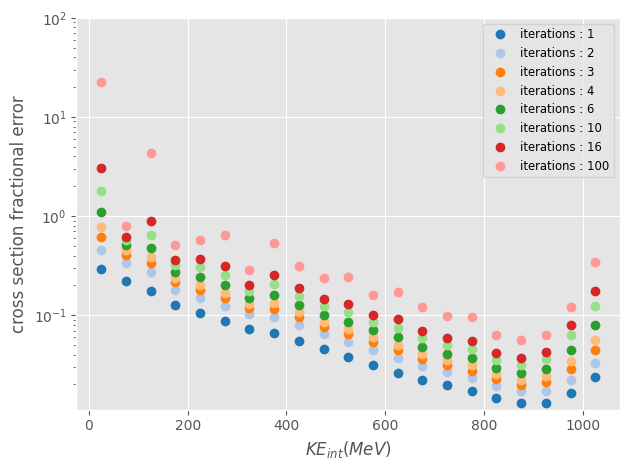

In [15]:
Plots.plt.figure()
for i, o in zip(iters, output):
    Plots.Plot(energy_slice.pos - energy_slice.width/2, cross_section.nandiv(o[1], o[0]), linestyle = "", marker = "o", y_scale = "log", xlabel = "$KE_{int} (MeV)$", ylabel = "cross section fractional error", label = f"iterations : {i}", newFigure = False)
    Plots.plt.ylim(0, 100)
# book.Save()

# Run for all True processes

In [75]:
for p in toy_template.truth_region_labels:
    odir = f"test/1GeV_toy/unfolding_{p}/"
    os.makedirs(odir, exist_ok = True)

    #* response matrices
    with Plots.PlotBook(odir + "response_matrices.pdf") as book:
        resp = cross_section.Unfold.CalculateResponseMatrices(toy_template, p, energy_slice, book)

    with Plots.PlotBook(odir + "toy_unfolding_PDSP_fit.pdf") as book:
        #* Generate observations
        histograms_true_obs, histograms_reco_obs, histograms_reco_obs_err = cex_analyse.BackgroundSubtraction(data_obs, p, energy_slice, fit_results, book)
        
        labels = {"init" : "$N_{init} (MeV)$", "int" : "$N_{int} (MeV)$", "int_ex" : "$N_{int,ex} (MeV)$", "inc" : "$N_{inc} (MeV)$"}

        for _, h in Plots.IterMultiPlot(histograms_reco_obs):
            Plots.Plot(energy_bins[::-1], histograms_reco_obs[h], xlabel = labels[h], style = "step", ylabel = "Counts", color = "C6", label = "reco", newFigure = False)
            Plots.Plot(energy_bins[::-1], histograms_true_obs[h], xlabel = labels[h], style = "step", ylabel = "Counts", color = "C0", label = "true", newFigure = False)
        book.Save()

        #* unfolding    
        results = cross_section.Unfold.Unfold(histograms_reco_obs, histograms_reco_obs_err, resp, ts_stop = 1E-2, ts = "bf", max_iter = 100)

        labels = {"init" : "$N_{init}$", "int" : "$N_{int}$", "int_ex" : "$N_{int, ex}$"}

        for k in results:
            cross_section.Unfold.PlotUnfoldingResults(histograms_reco_obs[k], histograms_true_obs[k], results[k], energy_bins, labels[k], book)

        n_incident_unfolded = cross_section.EnergySlice.NIncident(results["init"]["unfolded"], results["int"]["unfolded"])
        n_incident_unfolded_err = np.sqrt(results["int"]["stat_err"]**2 + np.cumsum(results["init"]["stat_err"]**2 + results["int"]["stat_err"]**2))

        Plots.Plot(energy_bins[::-1], histograms_reco_obs["inc"], style = "step", label = "reco", color = "C6")
        Plots.Plot(energy_bins[::-1], histograms_true_obs["inc"], style = "step", label = "true", color = "C0", newFigure = False)
        Plots.Plot(energy_bins[::-1], n_incident_unfolded, yerr = n_incident_unfolded_err, style = "step", label = "unfolded", xlabel = "$N_{inc}$ (MeV)", color = "C4", newFigure = False)
        book.Save()

        slice_dEdX = cross_section.EnergySlice.Slice_dEdX(energy_slice, cross_section.Particle.from_pdgid(211))
        xs = {
            "true" : cross_section.EnergySlice.CrossSection(histograms_true_obs["int_ex"][1:], histograms_true_obs["int"][1:], histograms_true_obs["inc"][1:], slice_dEdX, energy_slice.width),
            "reco" : cross_section.EnergySlice.CrossSection(histograms_reco_obs["int_ex"][1:], histograms_reco_obs["int"][1:], histograms_reco_obs["inc"][1:], slice_dEdX, energy_slice.width),
            f"unfolded" : cross_section.EnergySlice.CrossSection(results["int_ex"]["unfolded"][1:], results["int"]["unfolded"][1:], n_incident_unfolded[1:], slice_dEdX, energy_slice.width, results["int_ex"]["stat_err"][1:], results["int"]["stat_err"][1:], n_incident_unfolded_err[1:])
        }

        colors = ["C0", "C6", "C4"]
        colors = {k : colors[i] for i, k in enumerate(xs)}

        cross_section.PlotXSComparison(xs, energy_slice, p, colors = colors)
        book.Save()

        #* iterations study
        output = []
        iters = [1, 2, 3, 4, 6, 10, 16, 100]
        for i in iters:
            output.append(UnfoldXS(i, histograms_reco_obs, histograms_reco_obs_err, resp, energy_slice))

        chi_sqrs = []
        for n, i in Plots.IterMultiPlot(iters, xlim=(energy_slice.min_pos, energy_slice.max_pos), ylim = (0, np.nanmax(output))):
            chi_sqrs.append(cross_section.PlotXSComparison({f"iterations: {i}" : output[n]}, energy_slice, p, {f"iterations: {i}" : "C0"}, newFigure = False))
            Plots.plt.ylim(0)
        book.Save()

        Plots.plt.figure()
        for i, o in zip(iters, output):
            Plots.Plot(energy_slice.pos - energy_slice.width/2, cross_section.nandiv(o[1], o[0]), linestyle = "", marker = "o", y_scale = "log", xlabel = "$KE_{int} (MeV)$", ylabel = "cross section fractional error", label = f"iterations : {i}", newFigure = False)
            Plots.plt.ylim(0, 100)
        book.Save()

        table = pd.DataFrame({list(i.keys())[0]: [list(i.values())[0]] for i in chi_sqrs}, index = ["$\chi$^{2}/ndf$"]).T
        table.style.to_latex(odir + "chi_sqrs.tex")
    Plots.plt.close("all")

pdf test/1GeV_toy/unfolding_absorption/response_matrices.pdf has been opened
pdf test/1GeV_toy/unfolding_absorption/response_matrices.pdf has been closed
pdf test/1GeV_toy/unfolding_absorption/toy_unfolding_PDSP_fit.pdf has been opened
using KE_int,ex from region fit
signal: absorption
pdf test/1GeV_toy/unfolding_absorption/toy_unfolding_PDSP_fit.pdf has been closed
pdf test/1GeV_toy/unfolding_charge_exchange/response_matrices.pdf has been opened
pdf test/1GeV_toy/unfolding_charge_exchange/response_matrices.pdf has been closed
pdf test/1GeV_toy/unfolding_charge_exchange/toy_unfolding_PDSP_fit.pdf has been opened
using KE_int,ex from region fit
signal: charge_exchange
pdf test/1GeV_toy/unfolding_charge_exchange/toy_unfolding_PDSP_fit.pdf has been closed
pdf test/1GeV_toy/unfolding_single_pion_production/response_matrices.pdf has been opened
pdf test/1GeV_toy/unfolding_single_pion_production/response_matrices.pdf has been closed
pdf test/1GeV_toy/unfolding_single_pion_production/toy_unfo

# Example Unfolding

In [2]:
num_samples = int(1e5)
true_samples = np.random.normal(loc=0.0, scale=1.0, size=num_samples)
true_samples

array([ 0.18811101,  0.3567533 , -1.03867367, ...,  1.21420912,
        0.20883463, -1.02673854])

In [3]:
bins = np.linspace(-3, 3, 11)
num_bins = len(bins) - 1

In [4]:
data_true, _ = np.histogram(true_samples, bins=bins)
data_true

array([  677,  2743,  7919, 15861, 22460, 22633, 16063,  7967,  2712,
         683])

In [5]:
random_noise = np.random.normal(loc=0.3, scale=0.5, size=num_samples)
observed_samples = true_samples + random_noise

In [6]:
efficiencies = np.ones_like(bins, dtype=float)[1:]
# efficiencies = np.random.binomial(10, 0.4, num_bins)/10
efficiencies

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [7]:
efficiencies_err = np.full_like(efficiencies, 0.01, dtype=float)
efficiencies_err

array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])

In [8]:
data_observed, _ = np.histogram(observed_samples, bins=bins)
data_observed

array([  628,  2246,  5900, 12011, 18288, 21253, 18432, 12186,  5848,
        2235])

In [9]:
data_observed = data_observed * efficiencies
data_observed_err = np.sqrt(data_observed)

In [10]:
response, response_err = cross_section.Unfold.ResponseMatrix(observed_samples, true_samples, bins, efficiencies)

In [11]:
response.sum(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [12]:
unfolded_results = iterative_unfold(data=data_observed,
                                    data_err=data_observed_err,
                                    response=response,
                                    response_err=response_err,
                                    efficiencies=efficiencies,
                                    efficiencies_err=efficiencies_err,
                                    callbacks=[Logger()])

Iteration 1: ts = 0.1280, ts_stopping = 0.01
Iteration 2: ts = 0.0403, ts_stopping = 0.01
Iteration 3: ts = 0.0150, ts_stopping = 0.01
Iteration 4: ts = 0.0063, ts_stopping = 0.01


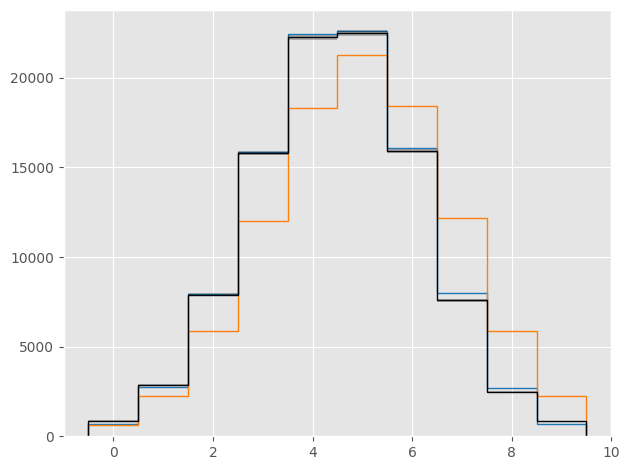

In [13]:
Plots.Plot(np.arange(num_bins), data_true, style = "step", color = "C0")
Plots.Plot(np.arange(num_bins), data_observed, style = "step", newFigure = False, color = "C2")
Plots.Plot(np.arange(num_bins), unfolded_results["unfolded"], yerr = unfolded_results["sys_err"], color = "k", style = "step", newFigure = False)

Text(0, 0.5, 'effect')

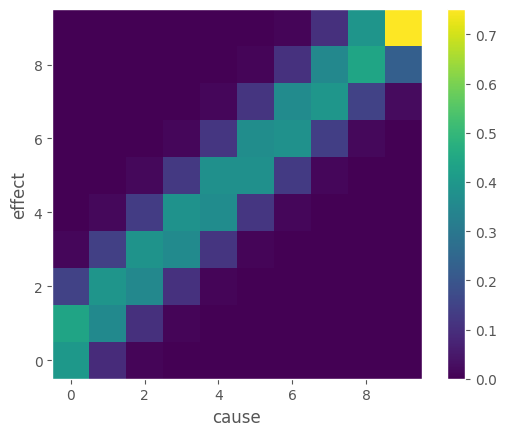

In [14]:
Plots.plt.imshow(response, origin = "lower")
Plots.plt.grid(False)
Plots.plt.colorbar()
Plots.plt.xlabel("cause")
Plots.plt.ylabel("effect")

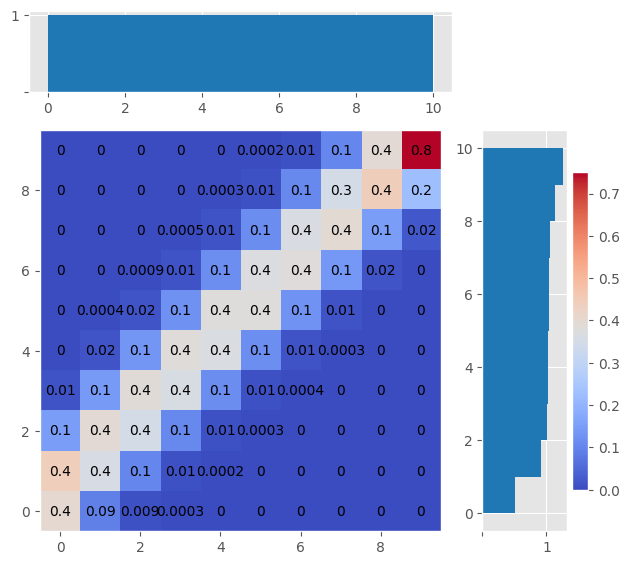

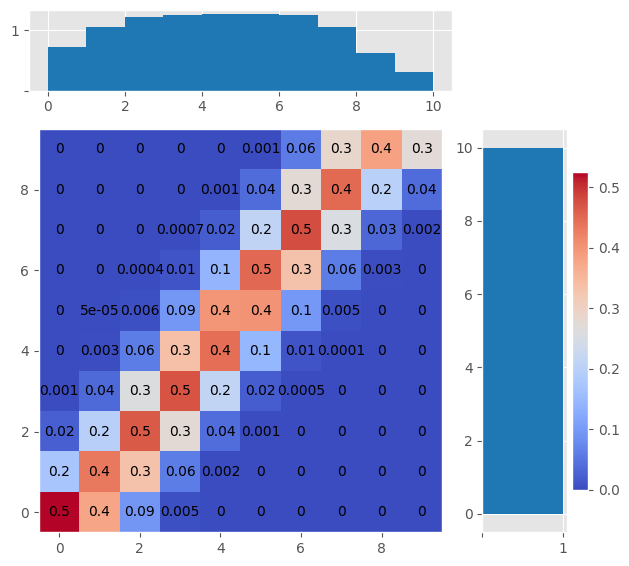

In [24]:
import matplotlib.pyplot as plt
def Plot(h):
    plt.subplots(2, 2, figsize = (6.4, 4.8 * 1.2), gridspec_kw={"height_ratios" : [1, 5], "width_ratios" : [4, 1]} , sharex = False, sharey = False) # set to that the ratio plot is 1/5th the default plot height
    plt.subplot(2, 2, 2).set_visible(False) # top right

    plt.subplot(2, 2, 3) # bottom left (main plot)
    # h, (x_e, y_e) = PlotHist2DImshow(data_x, data_y, bins, x_range, y_range, c_range, xlabel, ylabel, title, c_scale, norm, False, False, cmap)
    Plots.plt.imshow(h, origin = "lower", cmap = "coolwarm")
    Plots.plt.grid(False)
    # Plots.plt.colorbar()
    # Plots.plt.xlabel("cause")
    # Plots.plt.ylabel("effect")

    plt.subplot(2, 2, 1) # top right (x projection)
    plt.hist(np.arange(h.shape[0]), bins = np.arange(h.shape[0] + 1), weights = np.sum(h, 0), density = False)
    # # plt.xticks(ticks = x_e, labels = [])
    # plt.locator_params(axis='both', nbins=4)
    # plt.xlim(min(x_e), max(x_e))
    # plt.ylabel("fraction")
    plt.gca().yaxis.get_major_ticks()[0].label1.set_visible(False)

    plt.subplot(2, 2, 4) # bottom right (y projection)
    plt.hist(np.arange(h.shape[1]), bins = np.arange(h.shape[1] + 1), weights = np.sum(h, 1), density = False, orientation="horizontal")
    # # plt.yticks(ticks = y_e, labels = [])
    # plt.locator_params(axis='both', nbins=4)
    # plt.ylim(min(y_e), max(y_e))
    # plt.xlabel("fraction")
    plt.gca().xaxis.get_major_ticks()[0].label1.set_visible(False)

    plt.colorbar(ax = plt.gca())
    plt.tight_layout()
    plt.subplot(2, 2, 3) # switch back to main plot at the end

    for (i, j), z in np.ndenumerate(h):
        Plots.plt.gca().text(j, i, f"{z:.1g}", ha='center', va='center', fontsize = 10, color = "k")


Plot(response)
Plot(unfolded_results["unfolding_matrix"])

# Plots.Plot(np.arange(num_bins), np.sum(unfolded_results["unfolding_matrix"], 0), style = "step")
# Plots.Plot(np.arange(num_bins), np.sum(unfolded_results["unfolding_matrix"], 1), style = "step")


# Plots.Plot(np.arange(num_bins), unfolded_results["unfolded"], style = "step")
# Plots.Plot(np.arange(num_bins), np.matmul(data_observed, unfolded_results["unfolding_matrix"]), style = "step")
# Plots.Plot(np.arange(num_bins), np.matmul(unfolded_results["unfolding_matrix"], data_observed), style = "step")


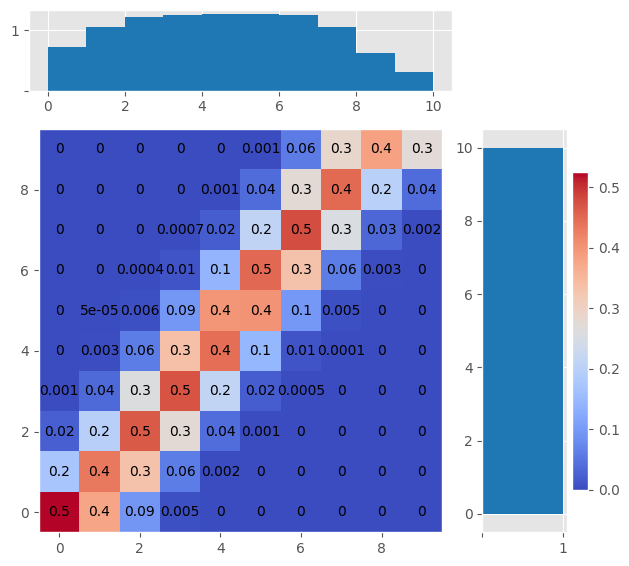

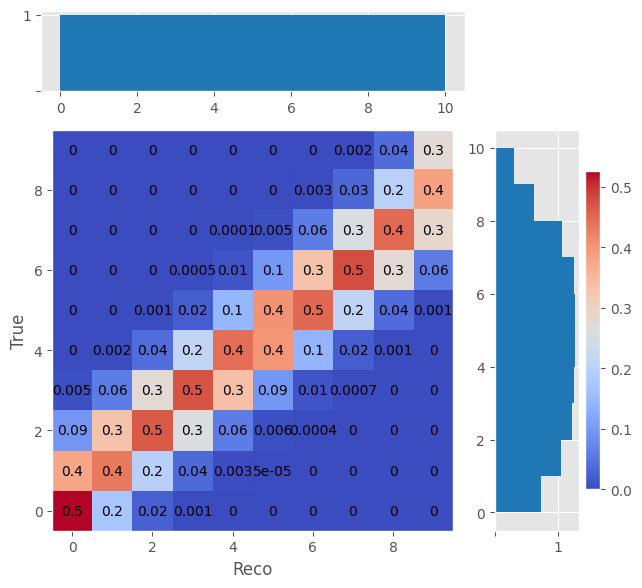

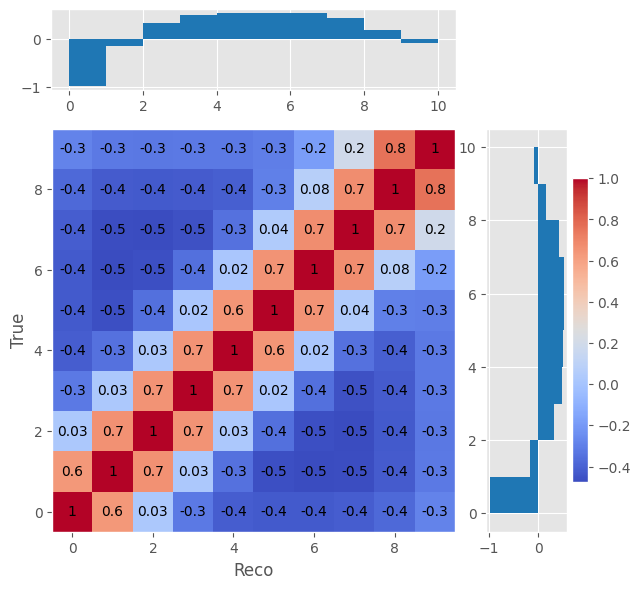

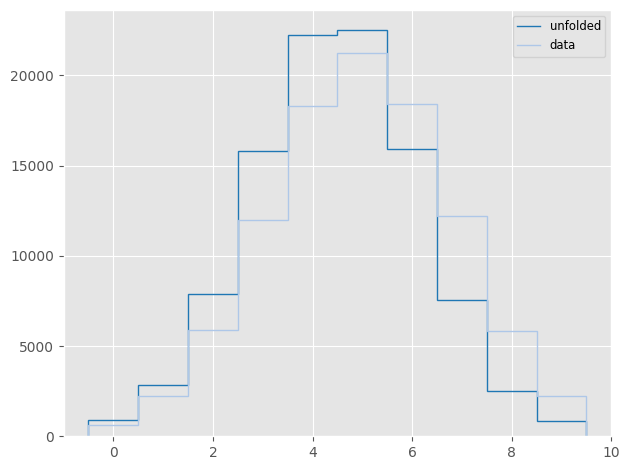

In [29]:
Plot(unfolded_results["unfolding_matrix"])

Plot(unfolded_results["unfolding_matrix"].T * data_observed / np.sum(unfolded_results["unfolding_matrix"].T * data_observed, 0))
Plots.plt.xlabel("Reco")
Plots.plt.ylabel("True")


Plot(np.corrcoef(unfolded_results["unfolding_matrix"].T * data_observed).T)
Plots.plt.xlabel("Reco")
Plots.plt.ylabel("True")


Plots.Plot(np.arange(num_bins), np.sum(unfolded_results["unfolding_matrix"].T * data_observed, 1), style = "step", label = "unfolded")
Plots.Plot(np.arange(num_bins), np.sum(unfolded_results["unfolding_matrix"].T * data_observed, 0), style = "step", label = "data", newFigure = False)


Text(68.21085858585859, 0.5, 'True')

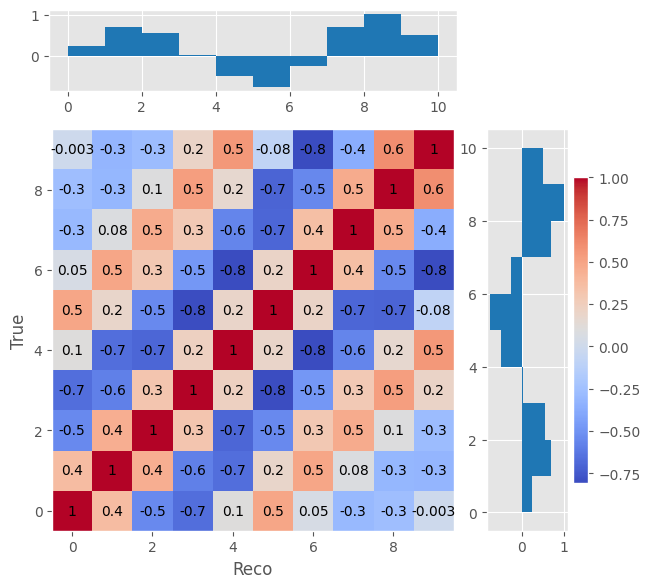

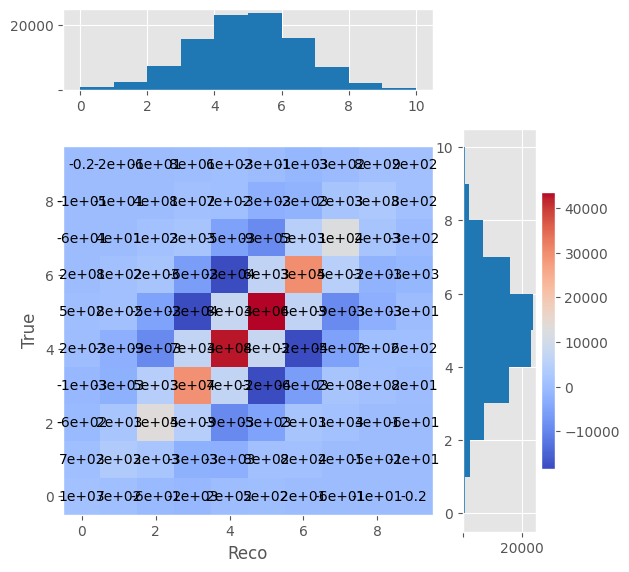

In [33]:
Plot(np.corrcoef(unfolded_results["covariance_matrix"]))
Plots.plt.xlabel("Reco")
Plots.plt.ylabel("True")

Plot(unfolded_results["covariance_matrix"])
Plots.plt.xlabel("Reco")
Plots.plt.ylabel("True")